In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.ensemble import IsolationForest
from imblearn.over_sampling import SMOTE
from sklearn import svm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pickle

In [20]:
df = pd.read_csv('diabetes.csv')


In [21]:
print("\nDataset Info:")
df.info()
print("\nMissing Values:")
print(df.isnull().sum())
print("\nClass Distribution:")
print(df['Outcome'].value_counts())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB

Missing Values:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    

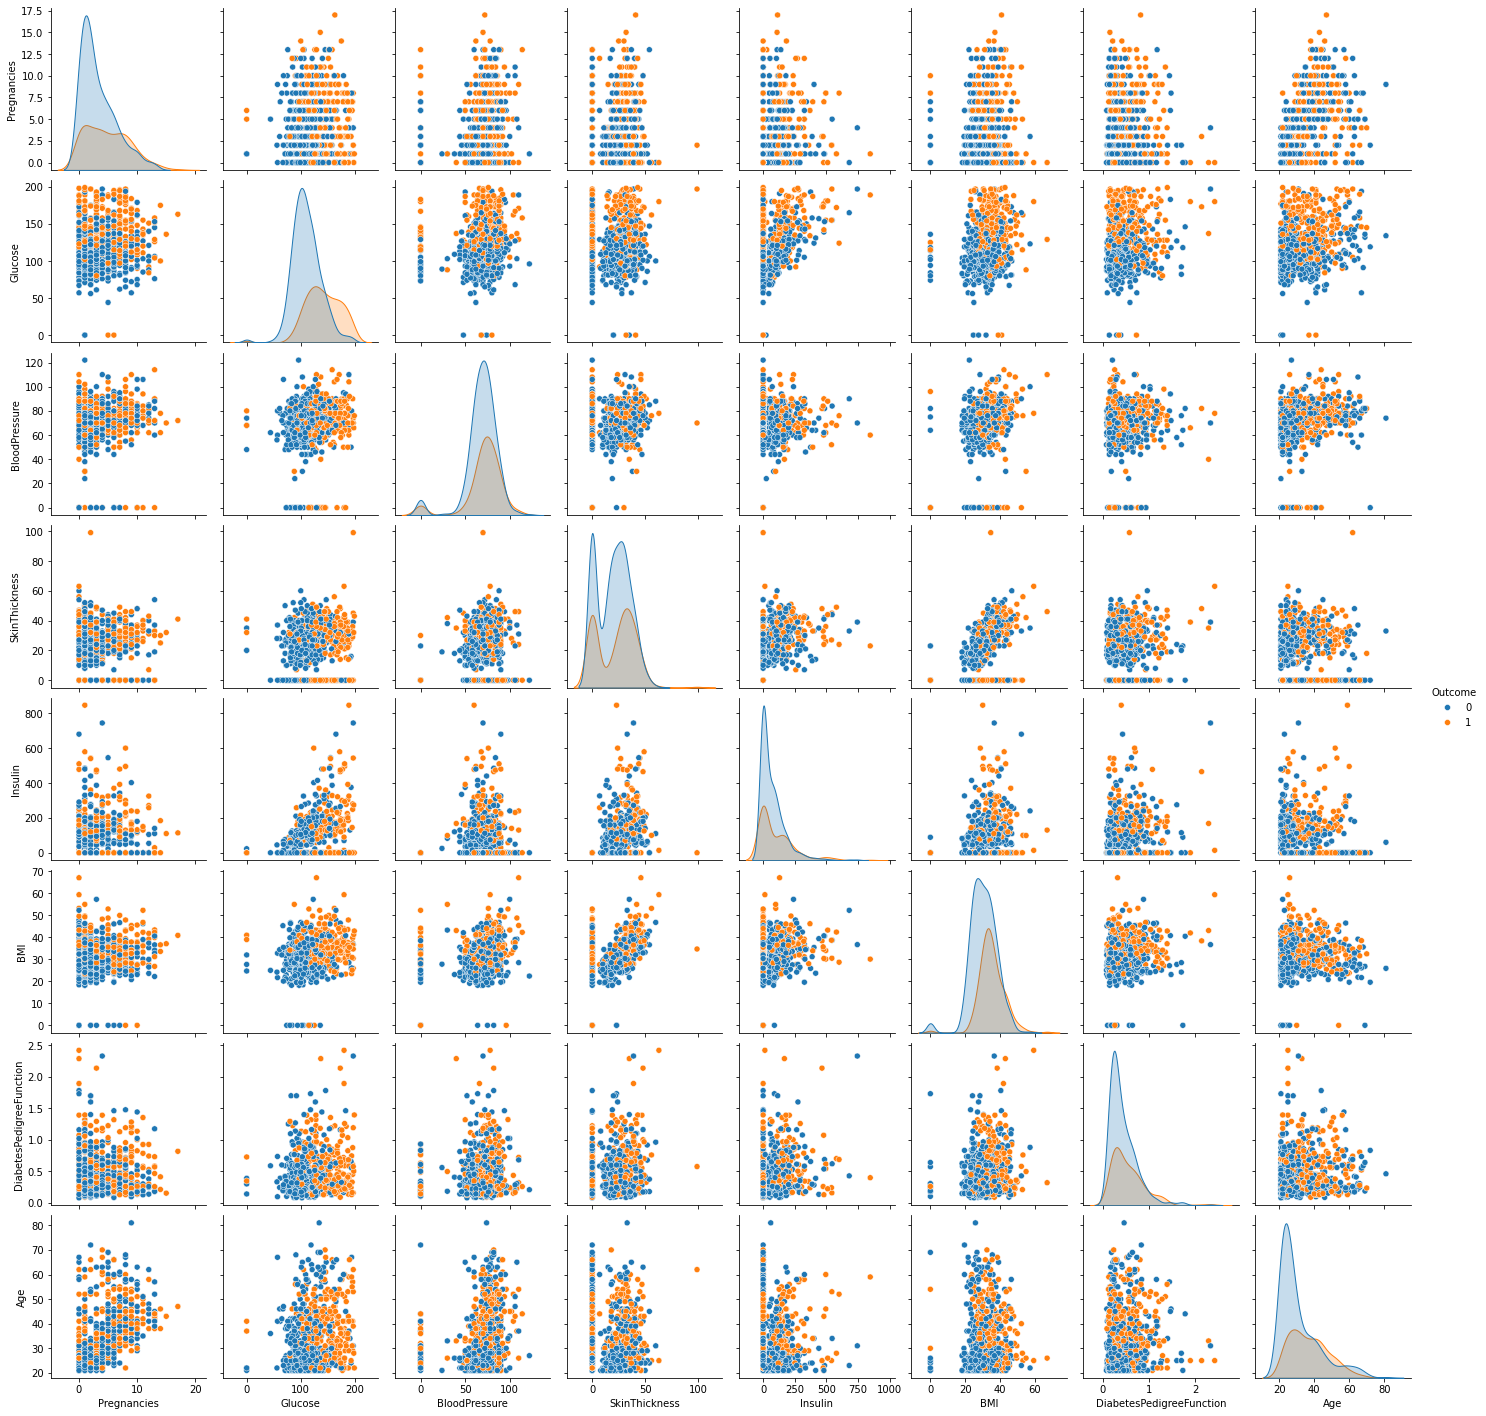

In [22]:
sns.pairplot(data=df, hue='Outcome')
plt.show()

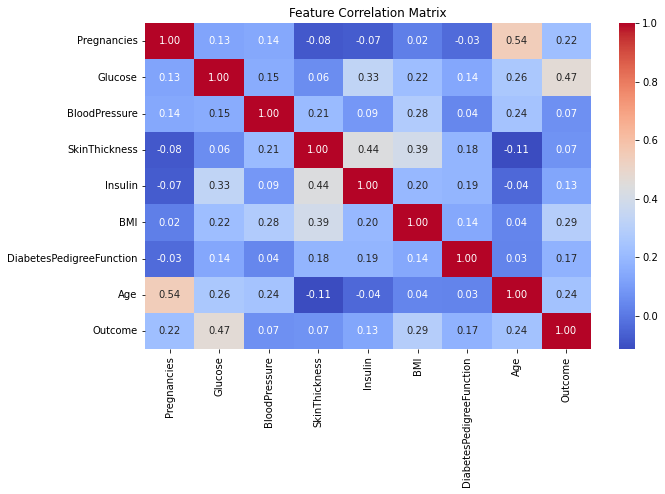

In [23]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Feature Correlation Matrix")
plt.show()

In [24]:
iso_forest = IsolationForest(contamination=0.05, random_state=42)
outliers = iso_forest.fit_predict(df.drop(columns=['Outcome']))
df = df[outliers == 1] 

C:\Users\USER\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [25]:
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(df.drop(columns=['Outcome']))
feature_names = poly.get_feature_names_out(df.drop(columns=['Outcome']).columns)
df_poly = pd.DataFrame(X_poly, columns=feature_names)
df_poly['Outcome'] = df['Outcome'].values

In [26]:
X = df_poly.drop(columns=['Outcome'])
y = df_poly['Outcome']


In [27]:
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42)


In [29]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [30]:
param_grid = {'C': [0.1, 1, 10], 'gamma': [1, 0.1, 0.01], 'kernel': ['rbf', 'poly'], 'degree': [2, 3, 4]}
model = svm.SVC()
from sklearn.model_selection import RandomizedSearchCV
random_search = RandomizedSearchCV(model, param_grid, n_iter=10, refit=True, verbose=2, cv=3, n_jobs=-1)
model = random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_


Fitting 3 folds for each of 10 candidates, totalling 30 fits


In [31]:
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy Score:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy Score: 0.844559585492228
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.79      0.84        97
           1       0.81      0.90      0.85        96

    accuracy                           0.84       193
   macro avg       0.85      0.84      0.84       193
weighted avg       0.85      0.84      0.84       193



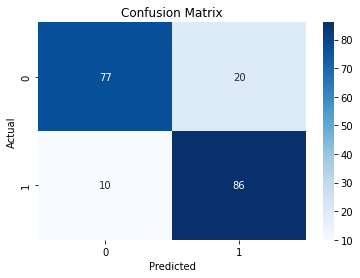

In [32]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [33]:
filename = 'diabetes_model.pkl'
with open(filename, 'wb') as file:
    pickle.dump(best_model, file)

print(f'Model has been saved as {filename}')


Model has been saved as diabetes_model.pkl
